<a href="https://colab.research.google.com/github/chaewoncutie/ADV-ML-tests/blob/main/KMeans_GMM_UMAP_SVD_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install necessary packages
!pip install -U scikit-learn nltk pandas matplotlib seaborn scipy wordcloud ipywidgets umap-learn

In [ ]:
# Import necessary libraries
import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from wordcloud import WordCloud
import numpy as np
import umap
from google.colab import files

In [ ]:
# Download stopwords
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
# Upload the JSON file
uploaded = files.upload()

# Read the JSON file
df = pd.read_json(next(iter(uploaded)), lines=True)
df = df[['headline', 'short_description']].dropna()
df['text'] = df['headline'] + " " + df['short_description']

df.head()

Saving News_Category_Dataset_v3.json to News_Category_Dataset_v3 (5).json


,headline,short_description,text
0,Over 4 Million Americans Roll Up Sleeves For O...,Health experts said it is too early to predict...,Over 4 Million Americans Roll Up Sleeves For O...
1,"American Airlines Flyer Charged, Banned For Li...",He was subdued by passengers and crew when he ...,"American Airlines Flyer Charged, Banned For Li..."
2,23 Of The Funniest Tweets About Cats And Dogs ...,"""Until you have a dog you don't understand wha...",23 Of The Funniest Tweets About Cats And Dogs ...
3,The Funniest Tweets From Parents This Week (Se...,"""Accidentally put grown-up toothpaste on my to...",The Funniest Tweets From Parents This Week (Se...
4,Woman Who Called Cops On Black Bird-Watcher Lo...,Amy Cooper accused investment firm Franklin Te...,Woman Who Called Cops On Black Bird-Watcher Lo...


In [ ]:
# Limit dataset size for faster processing
df = df.sample(n=50000, random_state=42)

# Preprocessing Function
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove punctuation & numbers
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

df['processed_text'] = df['text'].apply(preprocess_text)

In [ ]:
# Tokenize, remove stopwords, and apply lemmatization
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def tokenize_and_lemmatize(text):
    return ' '.join([lemmatizer.lemmatize(word) for word in word_tokenize(text) if word not in stop_words])

df['filtered_text'] = df['processed_text'].apply(tokenize_and_lemmatize)

In [ ]:
# TF-IDF Vectorization with optimized parameters
vectorizer = TfidfVectorizer(max_features=3000, stop_words='english', ngram_range=(1,2), max_df=0.8, min_df=10)
X = vectorizer.fit_transform(df['filtered_text'])

In [ ]:
# Dimensionality Reduction with SVD
svd = TruncatedSVD(n_components=30, random_state=42)
X_svd = svd.fit_transform(X)

In [ ]:
# UMAP for further non-linear reduction
umap_model = umap.UMAP(n_components=2, n_neighbors=30, min_dist=0.1, random_state=42)
X_umap = umap_model.fit_transform(X_svd)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [ ]:
# Normalize data
normalizer = Normalizer()
X_normalized = normalizer.fit_transform(X_umap)

In [ ]:
# Find best K using silhouette score and Calinski-Harabasz score
silhouette_scores = []
calinski_harabasz_scores = []
inertia_values = []
K = range(2, 15)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=50, init='k-means++')
    kmeans_labels = kmeans.fit_predict(X_normalized)
    sil_score = silhouette_score(X_normalized, kmeans_labels)
    calinski_score = calinski_harabasz_score(X_normalized, kmeans_labels)
    inertia = kmeans.inertia_
    silhouette_scores.append(sil_score)
    calinski_harabasz_scores.append(calinski_score)
    inertia_values.append(inertia)

    print(f'k={k}, silhouette score={sil_score}, Calinski-Harabasz score={calinski_score}, inertia={inertia}')

k=2, silhouette score=0.5070626735687256, Calinski-Harabasz score=52230.41789174236, inertia=24368.494140625
k=3, silhouette score=0.5881204009056091, Calinski-Harabasz score=83006.29197441223, inertia=11532.361328125
k=4, silhouette score=0.5859618186950684, Calinski-Harabasz score=101695.14849342407, inertia=7015.4443359375
k=5, silhouette score=0.6229761838912964, Calinski-Harabasz score=135612.23204024564, inertia=4204.6240234375
k=6, silhouette score=0.6416242122650146, Calinski-Harabasz score=167188.65193666224, inertia=2811.671142578125
k=7, silhouette score=0.6307052373886108, Calinski-Harabasz score=184562.6410395776, inertia=2152.2177734375
k=8, silhouette score=0.6260320544242859, Calinski-Harabasz score=192202.0806182918, inertia=1785.056396484375
k=9, silhouette score=0.6275029182434082, Calinski-Harabasz score=206761.77809670413, inertia=1461.665283203125
k=10, silhouette score=0.5602311491966248, Calinski-Harabasz score=227174.44847057012, inertia=1189.219482421875
k=11,

In [ ]:
# Select best K from silhouette scores
optimal_k = max(zip(K, silhouette_scores), key=lambda x: x[1])[0]

In [ ]:
# Apply final KMeans clustering
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=50)
df['kmeans_cluster'] = kmeans_final.fit_predict(X_normalized)

In [ ]:
# Apply Gaussian Mixture Model (GMM)
gmm = GaussianMixture(n_components=optimal_k, random_state=42)
df['gmm_cluster'] = gmm.fit_predict(X_normalized)
print(f'GMM clustering completed with best K={optimal_k}')

GMM clustering completed with best K=6


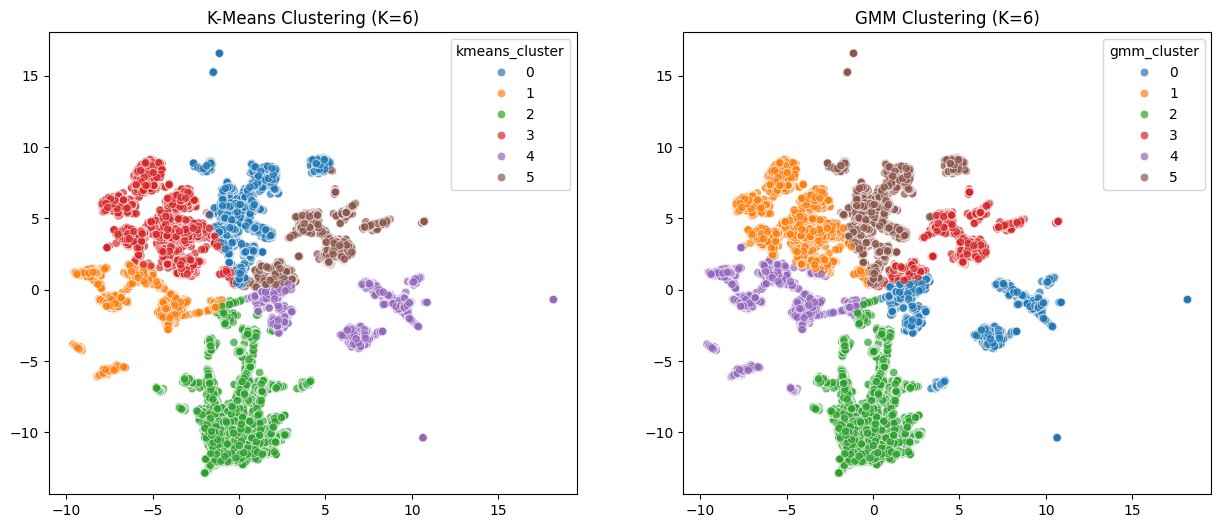

Clustering visualization completed.


In [ ]:
# Plot Clusters
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=df['kmeans_cluster'], palette='tab10', alpha=0.7, ax=axes[0])
axes[0].set_title(f'K-Means Clustering (K={optimal_k})')

sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=df['gmm_cluster'], palette='tab10', alpha=0.7, ax=axes[1])
axes[1].set_title(f'GMM Clustering (K={optimal_k})')

plt.show()
print("Clustering visualization completed.")

In [ ]:
# Generate Word Clouds for Clusters
def plot_wordclouds(df, cluster_column, model_name):
    clusters = sorted(df[cluster_column].unique())

    fig, axes = plt.subplots((len(clusters) // 2) + 1, 2, figsize=(15, len(clusters) * 3))
    axes = axes.flatten()

    for idx, cluster in enumerate(clusters):
        cluster_texts = df[df[cluster_column] == cluster]['filtered_text']
        wordcloud = WordCloud(width=400, height=400, background_color='white', colormap='tab10').generate(' '.join(cluster_texts))

        axes[idx].imshow(wordcloud, interpolation='bilinear')
        axes[idx].set_title(f'Cluster {cluster}')
        axes[idx].axis('off')

    plt.suptitle(f'Word Clouds for {model_name} Clusters')
    plt.tight_layout()
    plt.show()

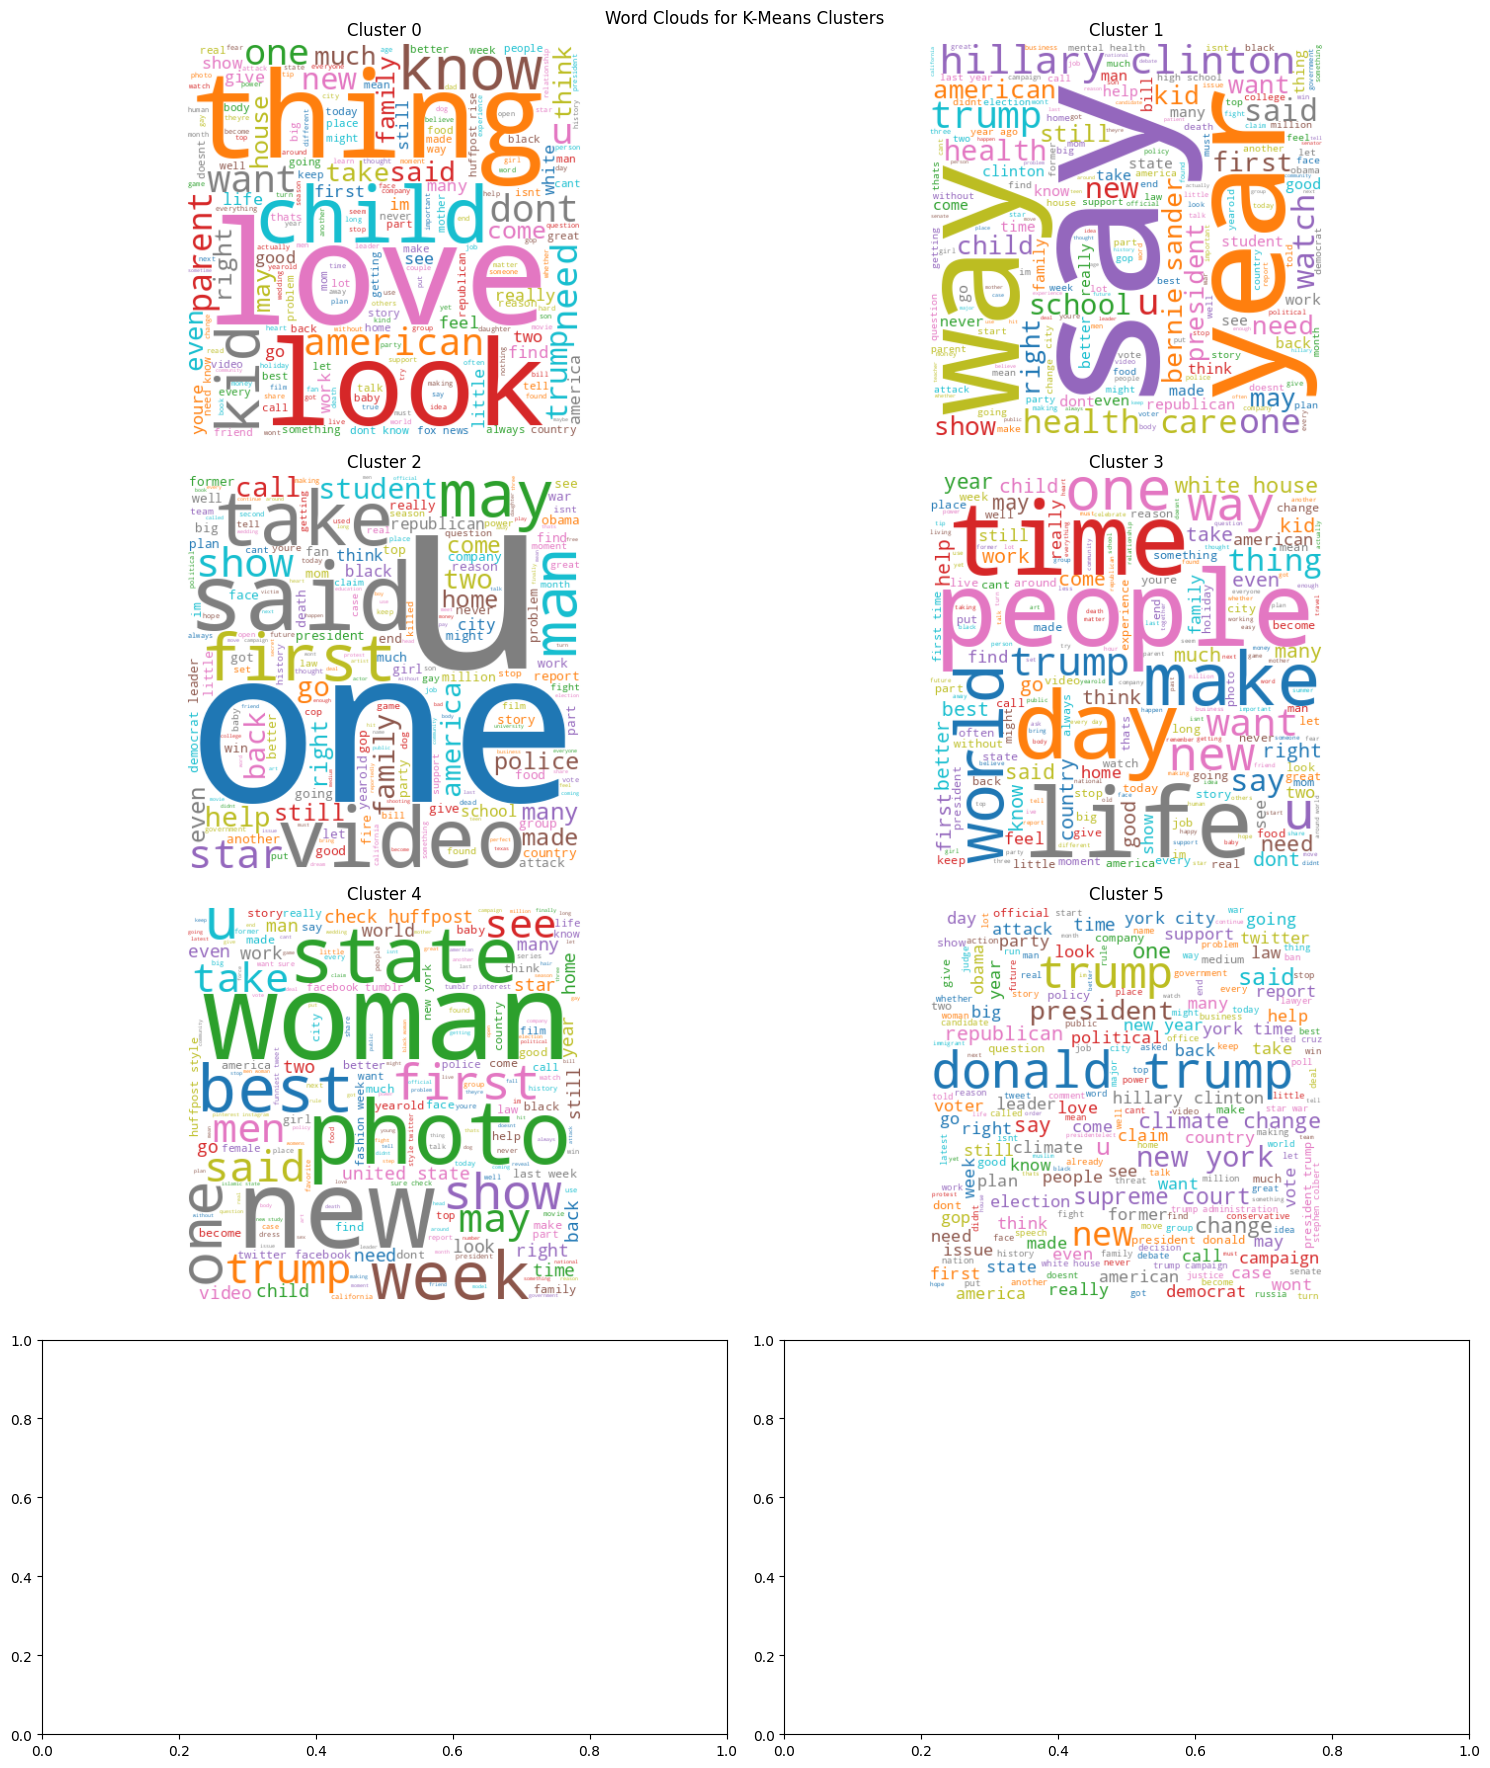

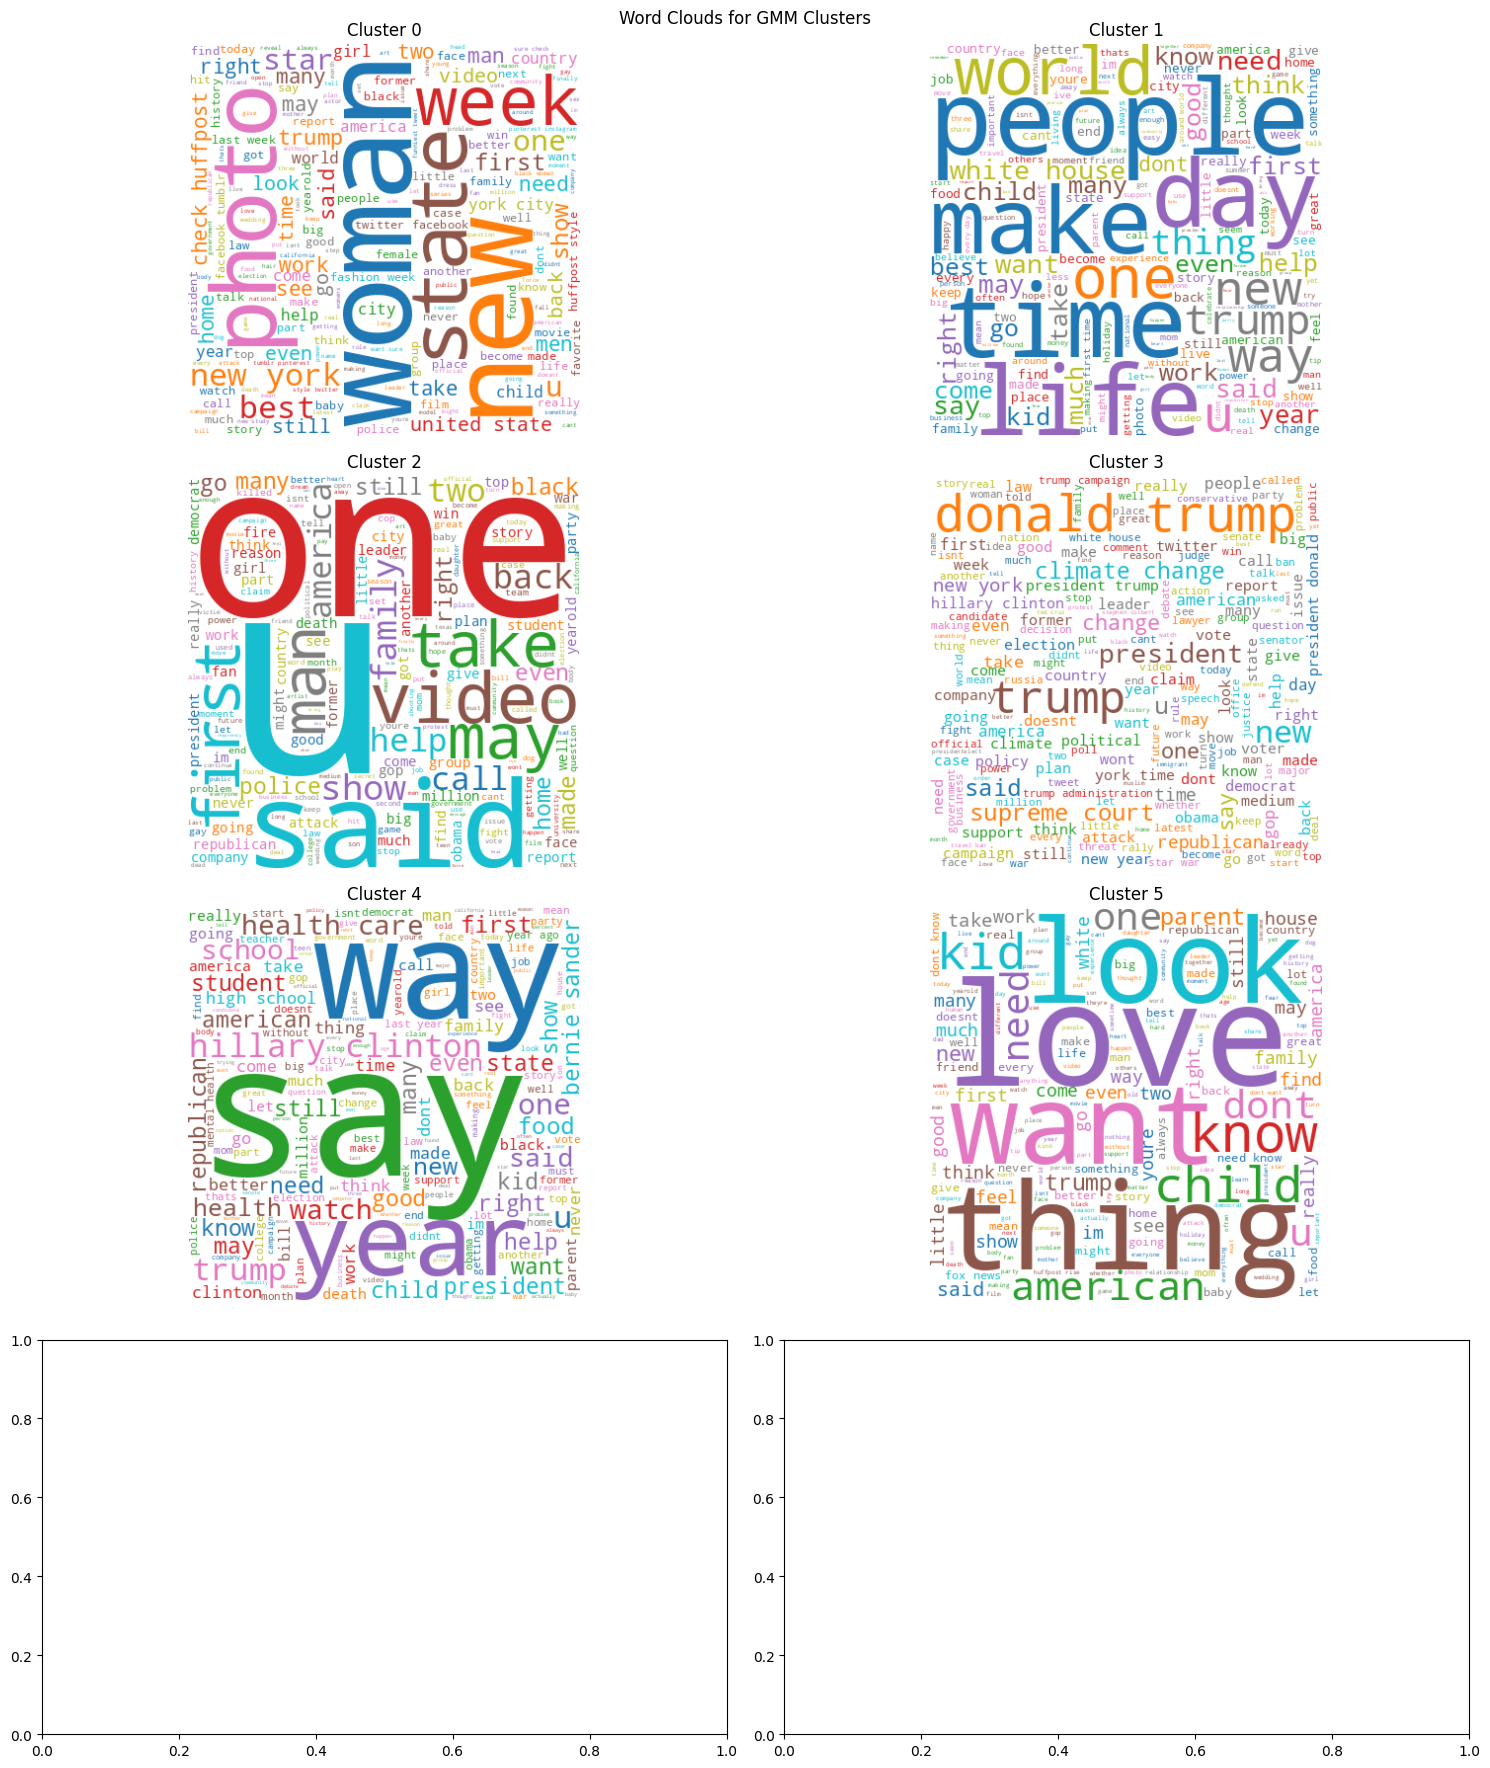

Word cloud visualization completed.


In [ ]:
# Plot Word Clouds for KMeans and GMM
plot_wordclouds(df, 'kmeans_cluster', 'K-Means')
plot_wordclouds(df, 'gmm_cluster', 'GMM')

print("Word cloud visualization completed.")